In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [587]:
filename1 = 'ecgid-90-update.csv'
filename2 = 'mimiciii_combined_98_subj.csv'
filename3 = 'nsrdb-18-subj.csv'
filename4 = 'arr-27-subj.csv'

df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)
df3 = pd.read_csv(filename3)
df4 = pd.read_csv(filename4)

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

#convert number-type to string-type for column Labels
df['Labels'] = df['Labels'].astype(str)
#save the combined df to csv file
df.to_csv('C:/Users/aimedic//PycharmProjects/ecg_authentication/mix1-v3.csv', index=False)
print(df.shape)
df.head(3)

(35237, 151)


,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,Labels
0,0.490672,0.422251,0.228106,-0.033556,-0.257353,-0.358802,-0.335725,-0.243806,-0.163921,-0.129047,...,-0.024464,-0.028554,-0.039117,-0.033131,0.018924,0.118015,0.250026,0.403574,0.505076,p01
1,0.509611,0.395481,0.137210,-0.151927,-0.330324,-0.348803,-0.269921,-0.181550,-0.138217,-0.134610,...,-0.064813,-0.063812,-0.069798,-0.072593,-0.036065,0.056388,0.193431,0.367346,0.499260,p01
2,0.511028,0.380736,0.056014,-0.261943,-0.390779,-0.339510,-0.226910,-0.157719,-0.144256,-0.139871,...,-0.004584,-0.007400,-0.012827,-0.017096,-0.011026,0.051504,0.185130,0.367359,0.520261,p01


In [487]:
#filename = 'arr-27-subj.csv'
#filename = 'nsrdb-18-subj.csv'
#filename = 'ecgid-90-update.csv'
filename = 'mimiciii_combined_98_subj.csv'
# filename = 'mix-215-subj.csv'
#filename = 'mixed2-199.csv'
#filename = 'mix1-172-update.csv'
# filename = 'mixed-215.csv'
df = pd.read_csv(filename)
#convert number-type to string-type for column Labels
df['Labels'] = df['Labels'].astype(str)

print(df.shape)
df.tail(3)

(16139, 151)


,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,Labels
16136,0.477865,0.434068,0.389884,0.316964,0.244045,0.171174,0.098998,0.043509,-0.010829,-0.044727,...,-0.084585,-0.049042,-0.012162,0.052212,0.117731,0.200421,0.283582,0.355717,0.427703,3999053
16137,0.484166,0.457217,0.429750,0.364027,0.298035,0.222255,0.146949,0.083032,0.020232,-0.022721,...,-0.104790,-0.082006,-0.058125,-0.008318,0.042570,0.115588,0.189212,0.263952,0.338707,3999053
16138,0.486111,0.442218,0.397900,0.322103,0.246271,0.169156,0.092745,0.033225,-0.025082,-0.061843,...,-0.084733,-0.053285,-0.020612,0.037292,0.096247,0.171482,0.247162,0.314192,0.381105,3999053


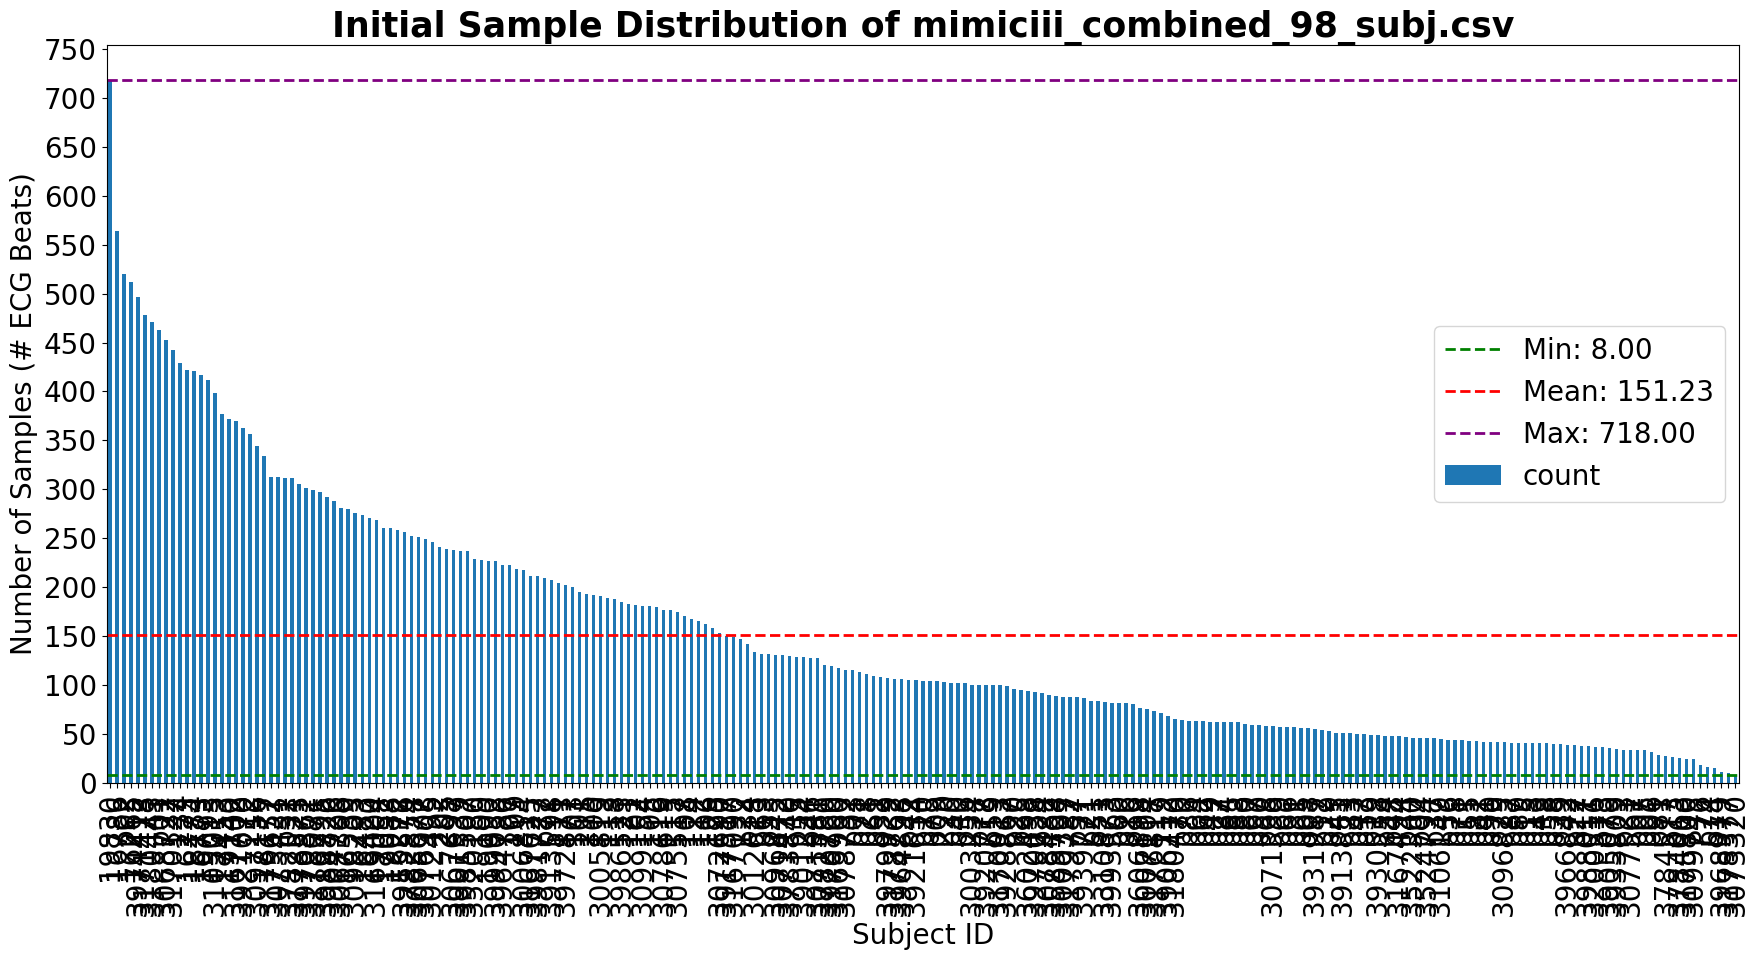

In [652]:
# Count the occurrences of each label
label_counts = df['Labels'].value_counts()
min_samples_count = label_counts.min()
mean_samples_count = label_counts.mean()
max_samples_count = label_counts.max()
# exit()
# Plot the labels numbers
plt.figure(figsize=(18, 10))
plt.rcParams['font.size']=20
label_counts.plot(kind='bar', )
plt.xlabel('Subject ID', fontsize =20)
plt.ylabel('Number of Samples (# ECG Beats)', fontsize =20)
# plt.title('Initial Sample Distribution of 172 Subjects from ECG-ID & MIMIC-III Databases', fontsize =25, fontweight='bold')
plt.title('Initial Sample Distribution of '+f'{filename}', fontsize =25, fontweight='bold')
plt.xticks(range(len(label_counts)), rotation=90)
plt.yticks(np.arange(0, max(label_counts)+60,50))
# Add a line indicating the average
plt.axhline(min_samples_count, color='green', linestyle='--', label=f'Min: {min_samples_count:.2f}', linewidth = 2.0)
plt.axhline(mean_samples_count, color='red', linestyle='--', label=f'Mean: {mean_samples_count:.2f}', linewidth = 2.0)
plt.axhline(max_samples_count, color='purple', linestyle='--', label=f'Max: {max_samples_count:.2f}', linewidth = 2.0)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [653]:
from sklearn.utils import resample

# Set the desired number of samples for each label
#desired_samples = int(mean_samples_count)
desired_samples = int(max_samples_count)
#desired_samples = 500
# Calculate the number of samples in each label
label_counts = df['Labels'].value_counts()

# Identify labels with more samples than desired
labels_to_downsample = label_counts[label_counts > desired_samples].index

# Identify labels with fewer samples than desired
labels_to_upsample = label_counts[label_counts <= desired_samples].index

# Create an empty DataFrame to store the balanced dataset
balanced_df = pd.DataFrame()

# Downsample labels with more samples than desired
for label in labels_to_downsample:
    label_data = df[df['Labels'] == label]
    downsampled_data = resample(label_data, replace=False, n_samples=desired_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, downsampled_data])

# Upsample labels with fewer samples than desired
for label in labels_to_upsample:
    label_data = df[df['Labels'] == label]
    upsampled_data = resample(label_data, replace=True, n_samples=desired_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, upsampled_data])

# Shuffle the balanced DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [654]:
print(balanced_df['Labels'].value_counts())

Labels
3955576    718
p01        718
121        718
102        718
p61        718
          ... 
p21        718
3784577    718
p49        718
3007104    718
p51        718
Name: count, Length: 233, dtype: int64


In [655]:
# data=df.iloc[:, 0:-1].values
# label=df.iloc[:,-1].values
# divide the data and the label
# for data, take all data from 1st col except the last col
# for label, take data only from the last col
data=balanced_df.iloc[:, 0:-1].values
label=balanced_df.iloc[:,-1].values
print(data.shape)
print(label.shape)
data

(167294, 150)
(167294,)


array([[3.01558564e-01, 2.61075668e-01, 2.13927153e-01, ...,
        1.75461010e-01, 2.28043958e-01, 2.77884251e-01],
       [1.51312442e+02, 1.20241225e+02, 7.66600017e+01, ...,
        6.27860158e+01, 1.00148820e+02, 1.38575171e+02],
       [1.93219204e-01, 1.68431825e-01, 1.29046626e-01, ...,
        9.96630280e-02, 1.41266268e-01, 1.79926430e-01],
       ...,
       [3.02047030e-01, 2.54771591e-01, 1.44392393e-01, ...,
        1.28924809e-01, 2.21814359e-01, 2.83907698e-01],
       [4.36302230e-01, 3.81911382e-01, 2.58696519e-01, ...,
        2.16264903e-01, 3.52472775e-01, 4.32663210e-01],
       [9.09937998e-01, 8.13012053e-01, 5.83144526e-01, ...,
        4.92573789e-01, 7.07881856e-01, 8.34124378e-01]])

In [656]:
# from collections import Counter
# from imblearn.combine import SMOTEENN
# # Create a SMOTEENN object
# smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
# # Fit and resample the dataset
# X_resampled, y_resampled = smote_enn.fit_resample(data, label)
# # print('before resampling: ', Counter(label))
# # print('after resampling: ', Counter(y_resampled))

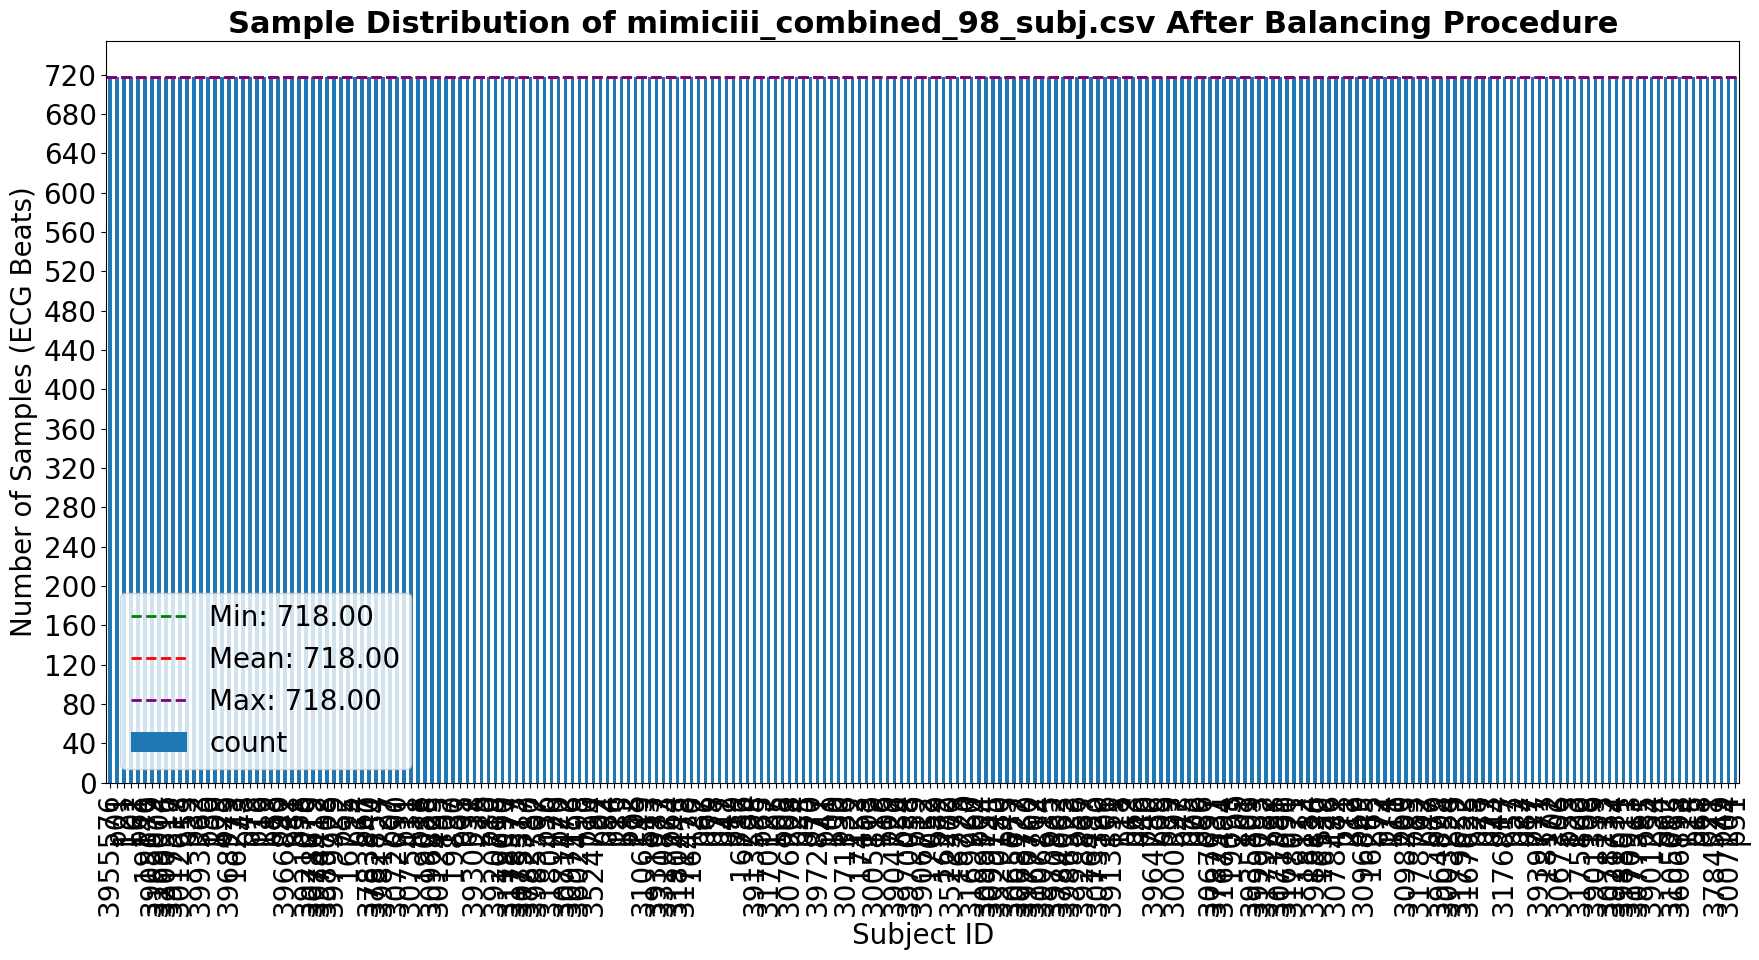

In [657]:
# Count the occurrences of each label
label_counts = balanced_df['Labels'].value_counts()
# label_with_min_samples = label_counts.idxmin()
min_samples_count = label_counts.min()
mean_samples_count = label_counts.mean()
max_samples_count = label_counts.max()
plt.figure(figsize=(18, 10))
# plt.rcParams['font.size']=20
label_counts.plot(kind='bar', )
plt.xlabel('Subject ID', fontsize =20)
plt.ylabel('Number of Samples (ECG Beats)', fontsize =20)
plt.title('Sample Distribution of '+f'{filename}'+' After Balancing Procedure', fontsize =22, fontweight='bold')
plt.xticks(range(len(label_counts)), rotation=90)
plt.yticks(np.arange(0, max(label_counts)+40,40))
# Add a line indicating the average
plt.axhline(min_samples_count, color='green', linestyle='--', label=f'Min: {min_samples_count:.2f}', linewidth = 2.0)
plt.axhline(mean_samples_count, color='red', linestyle='--', label=f'Mean: {mean_samples_count:.2f}', linewidth = 2.0)
plt.axhline(max_samples_count, color='purple', linestyle='--', label=f'Max: {max_samples_count:.2f}', linewidth = 2.0)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [658]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instance
scaler = StandardScaler()
# Fit the scaler to your data and transform the data
scaled_data = scaler.fit_transform(data)

In [659]:
#Convert label to binary
lb = LabelBinarizer()
label = lb.fit_transform(label)
print(label)
print(label.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(167294, 233)


In [660]:
# # #over/under sampling
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# scaled_data, label = smote.fit_resample(scaled_data, label)
# print(scaled_data.shape)

In [661]:
# X is the feature matrix and y is the label vector
X_train, X_valid, y_train, y_valid = train_test_split(scaled_data, label, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

#change the dimmension for CNN1D input
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_valid=X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

_, input_shape,_ = X_train.shape
_, n_class = y_train.shape


print('X_test: ', len(X_test))
print('X_valid: ', len(X_valid))
print('X_train: ', len(X_train))

X_test:  26767
X_valid:  33459
X_train:  107068


In [662]:
print(y_test.shape)
print(y_valid.shape)
print(y_train.shape)
print(n_class)

(26767, 233)
(33459, 233)
(107068, 233)
233


In [663]:
#MODEL 1
# define our Convolutional Neural Network architecture
model = Sequential()
# model.add(Conv1D(16, 3, padding="same", activation="relu", input_shape=(136, 1)))
model.add(Conv1D(16, 3, activation="relu", input_shape=(input_shape, 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(64, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(128, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(256, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(512, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 150, 16)           64        
                                                                 
 max_pooling1d_76 (MaxPooli  (None, 75, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_77 (Conv1D)          (None, 75, 32)            1568      
                                                                 
 max_pooling1d_77 (MaxPooli  (None, 37, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_38 (Flatten)        (None, 1184)              0         
                                                                 
 dense_76 (Dense)            (None, 100)             

In [664]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', patience=5, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint('mix3-233-max-v3.h5',
                             monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')

In [665]:
#compile model
opt = Adam(learning_rate=1e-3)
# opt = Adam(lr=1e-3, decay=1e-3)
# opt = SGD(learning_rate=0.01, momentum=0.3)
# opt = RMSprop(learning_rate=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
#train model
H = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=500, 
              batch_size=32, callbacks=[es, checkpoint], validation_batch_size=32)

Epoch 1/500
3346/3346 [==============================] - 11s 3ms/step - loss: 3.7861 - accuracy: 0.1826 - val_loss: 2.0887 - val_accuracy: 0.5295
Epoch 2/500
  55/3346 [..............................] - ETA: 9s - loss: 2.4534 - accuracy: 0.3665

C:\Users\aimedic\anaconda3\envs\ecg_Project\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3346/3346 [==============================] - 10s 3ms/step - loss: 1.8743 - accuracy: 0.5133 - val_loss: 1.0960 - val_accuracy: 0.7712
Epoch 3/500
3346/3346 [==============================] - 10s 3ms/step - loss: 1.3815 - accuracy: 0.6300 - val_loss: 0.8578 - val_accuracy: 0.8127
Epoch 4/500
3346/3346 [==============================] - 10s 3ms/step - loss: 1.1709 - accuracy: 0.6799 - val_loss: 0.7538 - val_accuracy: 0.8222
Epoch 5/500
3346/3346 [==============================] - 10s 3ms/step - loss: 1.0531 - accuracy: 0.7065 - val_loss: 0.6583 - val_accuracy: 0.8334
Epoch 6/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.9621 - accuracy: 0.7278 - val_loss: 0.5641 - val_accuracy: 0.8583
Epoch 7/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.9166 - accuracy: 0.7422 - val_loss: 0.5277 - val_accuracy: 0.8702
Epoch 8/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.8550 - accuracy: 0.7548 - val_loss: 0.5113 - val_accurac

Epoch 58/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2516 - accuracy: 0.9219 - val_loss: 0.1263 - val_accuracy: 0.9707
Epoch 59/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2508 - accuracy: 0.9235 - val_loss: 0.1726 - val_accuracy: 0.9530
Epoch 60/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2463 - accuracy: 0.9248 - val_loss: 0.0982 - val_accuracy: 0.9796
Epoch 61/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2459 - accuracy: 0.9251 - val_loss: 0.1138 - val_accuracy: 0.9760
Epoch 62/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2372 - accuracy: 0.9264 - val_loss: 0.1104 - val_accuracy: 0.9804
Epoch 63/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2319 - accuracy: 0.9268 - val_loss: 0.1192 - val_accuracy: 0.9772
Epoch 64/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.2381 - accuracy: 0.9270 - val_loss: 0

3346/3346 [==============================] - 10s 3ms/step - loss: 0.1566 - accuracy: 0.9526 - val_loss: 0.0571 - val_accuracy: 0.9896
Epoch 114/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1472 - accuracy: 0.9536 - val_loss: 0.0554 - val_accuracy: 0.9917
Epoch 115/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1541 - accuracy: 0.9536 - val_loss: 0.0726 - val_accuracy: 0.9888
Epoch 116/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1465 - accuracy: 0.9545 - val_loss: 0.0588 - val_accuracy: 0.9904
Epoch 117/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1459 - accuracy: 0.9532 - val_loss: 0.0574 - val_accuracy: 0.9868
Epoch 118/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1525 - accuracy: 0.9529 - val_loss: 0.0605 - val_accuracy: 0.9888
Epoch 119/500
3346/3346 [==============================] - 10s 3ms/step - loss: 0.1512 - accuracy: 0.9541 - val_loss: 0.0861 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


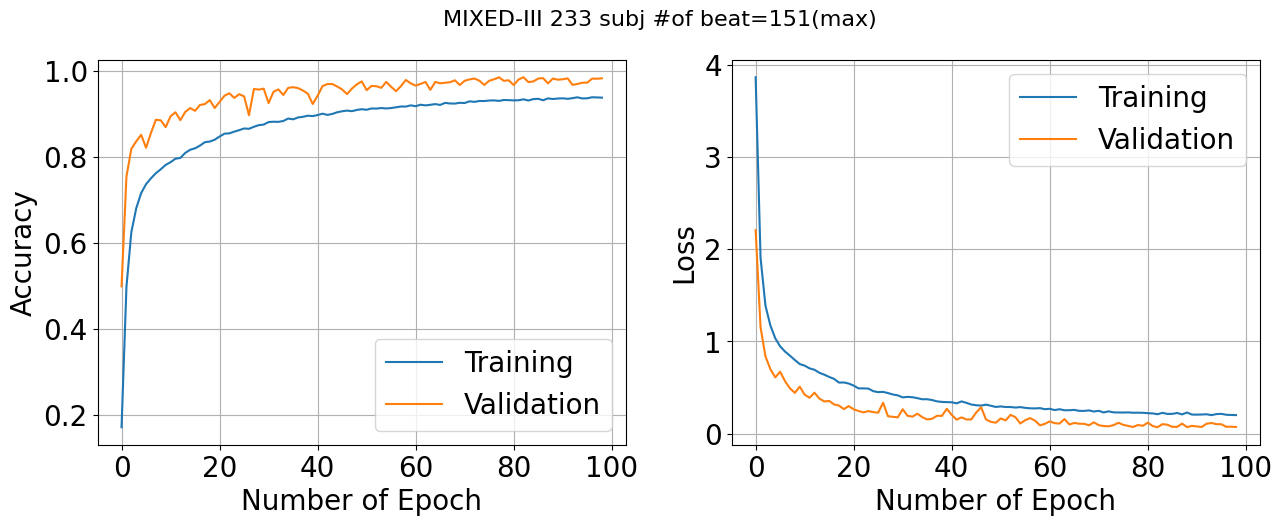

train-acc:  0.9382728934288025
val-acc:  0.9848769903182983
train-loss:  3.8635776042938232
val-loss:  2.205944776535034


In [633]:
name_db="MIXED-III 233"
temp="max"

print(H.history.keys())
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches([15,5])
# fig.suptitle('NSRDB-18 subj without sample balancing-Do0.2-Bs32', fontsize=16)
# fig.suptitle('NSRDB-18 subj #of beat=718(max)-Do0.2-Bs32', fontsize=16)
fig.suptitle('{} subj #of beat=151({})'.format(name_db, temp), fontsize=16)

ax1.plot(H.history['accuracy'])
ax1.plot(H.history['val_accuracy'])
# ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Epoch')
ax1.legend(['Training', 'Validation'], loc='lower right')
ax1.grid()
# ax1.set_legend(['Training', 'Validation'], loc='lower right')
# plt.grid()
# plt.savefig("Accuracy_70sample_model1_dwt_smote.png")
# plt.show()
# summarize history for loss
ax2.plot(H.history['loss'])
ax2.plot(H.history['val_loss'])
# ax2.set_title('loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Number of Epoch')
ax2.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.savefig("acc_loss_mix3_{}.png".format(temp), bbox_inches="tight", dpi=300)
plt.show()

print('train-acc: ', np.max(H.history['accuracy']))
print('val-acc: ', np.max(H.history['val_accuracy']))
print('train-loss: ', np.max(H.history['loss']))
print('val-loss: ', np.max(H.history['val_loss']))

In [634]:
#load model
#model = tf.keras.models.load_model('best_weight_mix201-mean-do02-bs32.h5')

In [651]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=32)
target_names=list(map(str,lb.classes_))
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names, digits=4)
print(report)

[INFO] evaluating network...
583/583 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

         100     0.9867    1.0000    0.9933        74
         101     0.5689    1.0000    0.7252        95
         102     0.9892    1.0000    0.9946        92
         103     0.9737    0.4684    0.6325        79
         105     0.9894    1.0000    0.9947        93
         106     0.4468    0.8750    0.5915        72
         107     1.0000    1.0000    1.0000        79
         108     0.9239    0.9770    0.9497        87
         109     1.0000    1.0000    1.0000        82
         111     0.9881    0.9326    0.9595        89
         112     1.0000    0.9868    0.9934        76
         113     1.0000    0.9459    0.9722        74
         115     0.8554    0.9467    0.8987        75
         116     1.0000    1.0000    1.0000        77
         118     1.0000    0.9740    0.9868        77
         119     1.0000    1.0000    1.0000        

C:\Users\aimedic\anaconda3\envs\ecg_Project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimedic\anaconda3\envs\ecg_Project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aimedic\anaconda3\envs\ecg_Project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

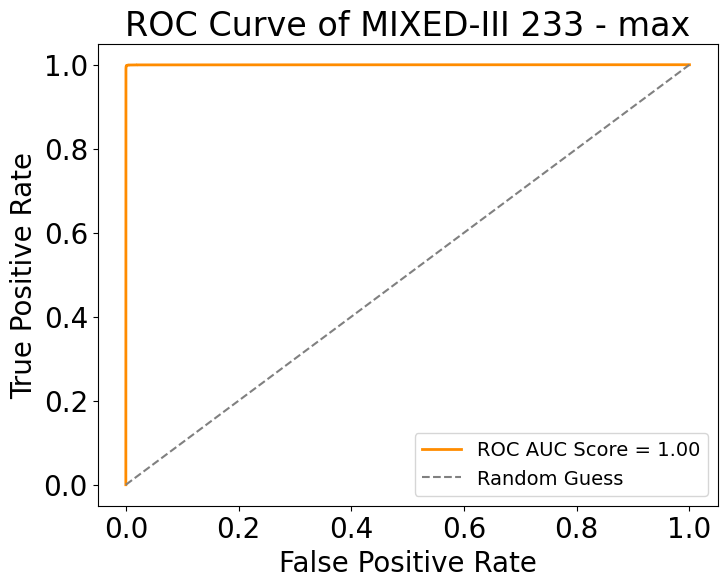

In [628]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

#name_db="NSRDB 18"
#temp="mean"

y_pred_prob = np.squeeze(predictions)

# Compute the micro-averaged ROC curve and AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
np.save('np_fpr_{}_{}.npy'.format(name_db, temp), fpr_micro)
np.save('np_tpr_{}_{}.npy'.format(name_db, temp), tpr_micro)

# Plot the micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label=f'ROC AUC Score = {roc_auc_micro:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of {} - {}'.format(name_db, temp))
plt.legend(fontsize="14")
plt.savefig("Fig_ROC_{}_{}.png".format(name_db, temp), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create or open a CSV file for writing
import csv
with open('report-nsrdb-18-max-do02-bs32.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Split the classification report by lines
    lines = report.split('\n')
    for line in lines:
        # Split each line by whitespace
        row = line.split()
        writer.writerow(row)

print("Classification report saved to 'classification_report.csv'")

In [ ]:
confusion_matrix = np.zeros((n_class, n_class))
for i in range(len(predictions)):
    predicted_class = predictions.argmax(axis=1)[i]
    true_class = y_test.argmax(axis=1)[i]
    confusion_matrix[true_class, predicted_class] += 1
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
# plt.savefig("Confussion_Matrix_model1_90person.png", bbox_inches='tight')



# K-Folds

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_k = EarlyStopping(monitor='loss', patience=5, mode='auto', restore_best_weights=True)
checkpoint_k = ModelCheckpoint('best_weight_ecgid-wob-do02-bs32-kf5.h5',
                             monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto',)

In [10]:
import numpy as np
#K-fold cross validation
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
inputs = np.concatenate((X_train, X_valid), axis=0)
targets = np.concatenate((y_train, y_valid), axis=0)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
acc_per_fold=[]
loss_per_fold=[]

for train, test in kfold.split(X_train, y_train):
    
  model_k = Sequential()
  model_k.add(Conv1D(16, 3, activation="relu", input_shape=(input_shape, 1), padding='same'))
  model_k.add(MaxPooling1D(pool_size=2))
  model_k.add(Conv1D(32, 3, activation='relu'))
  model_k.add(MaxPooling1D(pool_size=2))
  model_k.add(Flatten())
  model_k.add(Dense(100, activation='relu'))
  model_k.add(Dropout(0.2))
  model_k.add(Dense(n_class, activation='softmax'))
  #compile the model
  model_k.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

  # Generate a print
  print('————————————————————————————————————')
  print('Training for fold {}'.format(fold_no))

  # Fit data to model
  H = model_k.fit(inputs[train], targets[train],
              batch_size=32,
              epochs=500,
              verbose=1,
              callbacks=[es_k, checkpoint_k],
              validation_data=(X_valid, y_valid))

  # Generate generalization metrics
  scores = model_k.evaluate(inputs[test], targets[test], verbose=0)
  print('Score for fold {}: {} of {}; {} of {}%'.format(fold_no, model_k.metrics_names[0], scores[0],
                                                        model_k.metrics_names[1], scores[1]*100))
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

————————————————————————————————————
Training for fold 1
Epoch 1/500
114/114 [==============================] - 1s 4ms/step - loss: 4.0669 - accuracy: 0.1122 - val_loss: 3.4055 - val_accuracy: 0.2252
Epoch 2/500
 63/114 [===============>..............] - ETA: 0s - loss: 3.0460 - accuracy: 0.2857

C:\Users\aimedic\anaconda3\envs\ecg_Project\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 0s 3ms/step - loss: 2.7235 - accuracy: 0.3466 - val_loss: 1.8382 - val_accuracy: 0.5306
Epoch 3/500
114/114 [==============================] - 0s 3ms/step - loss: 1.7092 - accuracy: 0.5356 - val_loss: 1.1583 - val_accuracy: 0.7129
Epoch 4/500
114/114 [==============================] - 0s 3ms/step - loss: 1.3902 - accuracy: 0.6407 - val_loss: 0.9059 - val_accuracy: 0.7650
Epoch 5/500
114/114 [==============================] - 0s 3ms/step - loss: 0.9844 - accuracy: 0.7139 - val_loss: 0.6657 - val_accuracy: 0.8290
Epoch 6/500
114/114 [==============================] - 0s 3ms/step - loss: 0.8044 - accuracy: 0.7664 - val_loss: 0.5384 - val_accuracy: 0.8705
Epoch 7/500
114/114 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.8014 - val_loss: 0.4561 - val_accuracy: 0.8867
Epoch 8/500
114/114 [==============================] - 0s 3ms/step - loss: 0.5599 - accuracy: 0.8341 - val_loss: 0.3910 - val_accuracy: 0.9036
Epoch 9/500

114/114 [==============================] - 0s 3ms/step - loss: 0.1261 - accuracy: 0.9601 - val_loss: 0.2657 - val_accuracy: 0.9669
Epoch 24/500
114/114 [==============================] - 0s 3ms/step - loss: 0.1202 - accuracy: 0.9598 - val_loss: 0.2845 - val_accuracy: 0.9578
Epoch 25/500
114/114 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9620 - val_loss: 0.2782 - val_accuracy: 0.9613
Epoch 26/500
114/114 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9601 - val_loss: 0.2820 - val_accuracy: 0.9641
Epoch 27/500
114/114 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 0.9648 - val_loss: 0.2844 - val_accuracy: 0.9634
Epoch 28/500
114/114 [==============================] - 0s 3ms/step - loss: 0.0991 - accuracy: 0.9673 - val_loss: 0.2787 - val_accuracy: 0.9627
Epoch 29/500
114/114 [==============================] - 0s 3ms/step - loss: 0.1064 - accuracy: 0.9678 - val_loss: 0.2749 - val_accuracy: 0.9634
Epoch

In [ ]:
acc_per_fold

In [ ]:
mean_acc = np.array(acc_per_fold).mean()
mean_loss = np.array(loss_per_fold).mean()

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_per_fold) + 1), acc_per_fold, marker='o')
plt.axhline(mean_acc, color='red', linestyle='--', label=f'Mean: {mean_acc:.2f}')
plt.title('Accuracy for Each Fold - 90 Subj')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_per_fold) + 1), loss_per_fold, marker='o')
plt.axhline(mean_loss, color='red', linestyle='--', label=f'Mean: {mean_loss:.2f}')
plt.title('Loss for Each Fold - 90 Subj')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#load model
# model = tf.keras.models.load_model('best_weight_mimic-wob-do02-bs32-kf5.h5')
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=32)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)
target_names=list(map(str,lb.classes_))
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names, digits=4)
print(report)